# Data Loading

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def symbol_to_path(symbol, base_dir="data"):
    """Return CSV file path given ticker symbol."""
    return os.path.join(base_dir, "{}.csv".format(str(symbol)))


def get_data(symbols, dates):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df = pd.DataFrame(index=dates)
    if 'SPY' not in symbols:  # add SPY for reference, if absent
        symbols.insert(0, 'SPY')

    for symbol in symbols:
        df_temp = pd.read_csv(symbol_to_path(symbol), index_col='Date',
                              parse_dates=True, usecols=['Date', 'Adj Close'], na_values=['nan'],
                              infer_datetime_format=True)[0:-1]
        df_temp = df_temp.rename(columns={'Adj Close': symbol})
        #print(symbol)
        #print(df_temp)
        df = df.join(df_temp)
        if symbol == 'SPY':  # drop dates SPY did not trade
            df = df.dropna(subset=["SPY"])

    return df


def plot_data(df, title="Stock prices", xlabel="Date", ylabel="Price"):
    """Plot stock prices with a custom title and meaningful axis labels."""
    ax = df.plot(title=title, fontsize=12)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.draw()
    plt.show()

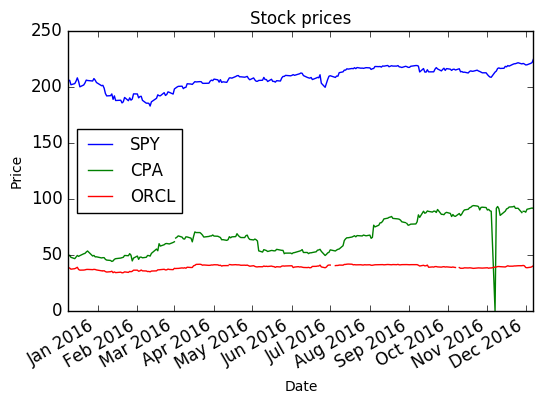

In [2]:
dates = pd.date_range('2015-12-08', '2016-12-07')  # one month only
symbols = ['SPY','CPA', 'ORCL']
df = get_data(symbols, dates)
#print(df)
plot_data(df)

# Data Cleanup

In [3]:
def fill_missing_values(df_data):
    """Fill missing values in data frame, in place."""
    df_data.fillna(method='ffill', inplace=True)
    df_data.fillna(method='bfill', inplace=True)

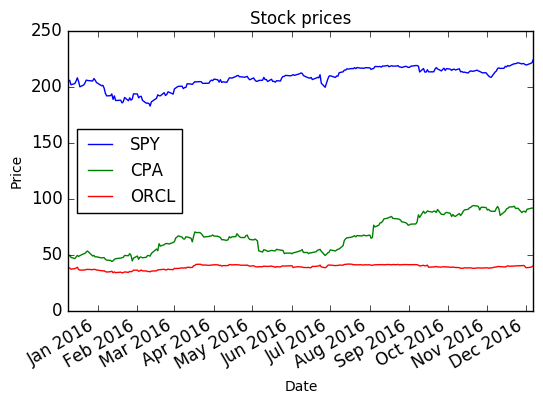

In [4]:
df[df==0] = np.nan
fill_missing_values(df)
#df.to_csv('data/clean_data.csv')
plot_data(df)

# Bollinger Bands


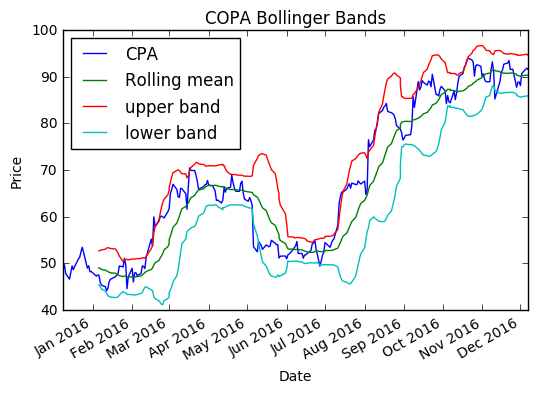

In [5]:
def bollinger_bands(mean, standard_dev):
    upper = mean + standard_dev * 2
    lower = mean - standard_dev * 2
    return upper, lower

rolling_mean_copa = df['CPA'].rolling(20).mean()
rolling_std_dev_copa = df['CPA'].rolling(20).std()
upper, lower = bollinger_bands(rolling_mean_copa, rolling_std_dev_copa)

ax = df['CPA'].plot(title="COPA Bollinger Bands", label='CPA')
rolling_mean_copa.plot(label='Rolling mean', ax=ax)
upper.plot(label='upper band', ax=ax)
lower.plot(label='lower band', ax=ax)

# Add axis labels and legend
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.legend(loc='upper left')
plt.show()

# Daily Returns

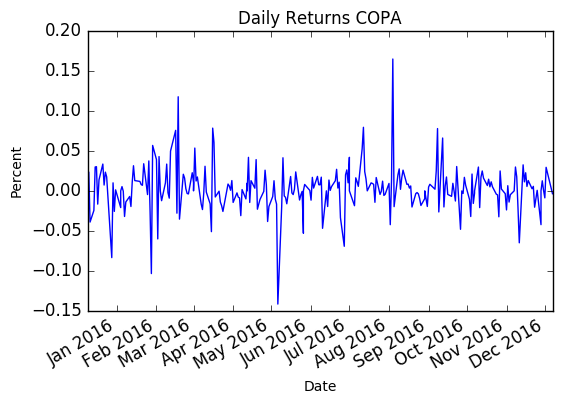

In [6]:
def compute_daily_returns(df):
    daily_returns = df.copy()
    daily_returns[1:] = (df[1:] / df[:-1].values) - 1
    daily_returns.ix[0, :] = 0
    return daily_returns

daily_returns = compute_daily_returns(df)
plot_data(daily_returns['CPA'], title='Daily Returns COPA', ylabel='Percent')

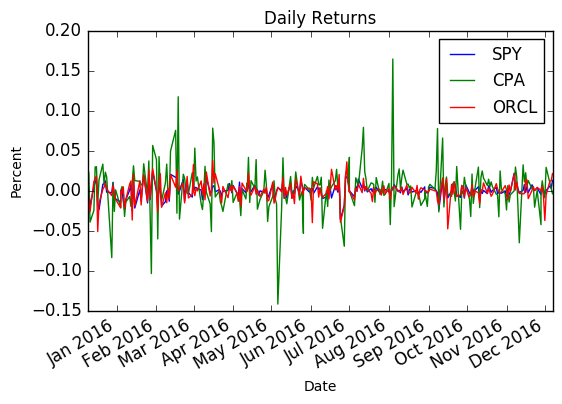

In [7]:
plot_data(daily_returns, title='Daily Returns', ylabel='Percent')

Mean 0.0028516314235981005
Std 0.028880422659113038


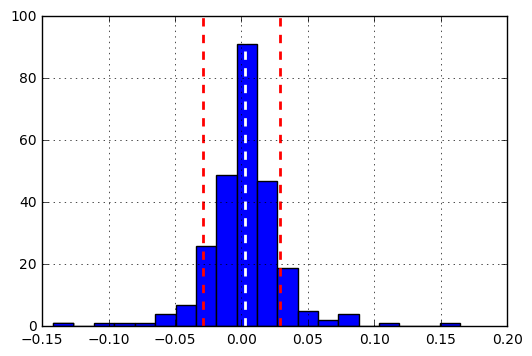

In [8]:
daily_returns['CPA'].hist(bins=20)
mean = daily_returns['CPA'].mean()
std =  daily_returns['CPA'].std()

print('Mean {}'.format(mean))
print('Std {}'.format(std))

plt.axvline(mean, color='w', linestyle='dashed', linewidth=2)
plt.axvline(std, color='r', linestyle='dashed', linewidth=2)
plt.axvline(-std, color='r', linestyle='dashed', linewidth=2)

plt.show()

# Scatter plots

Beta COPA 1.162345747056753
Alpha COPA 0.0024083544434719407


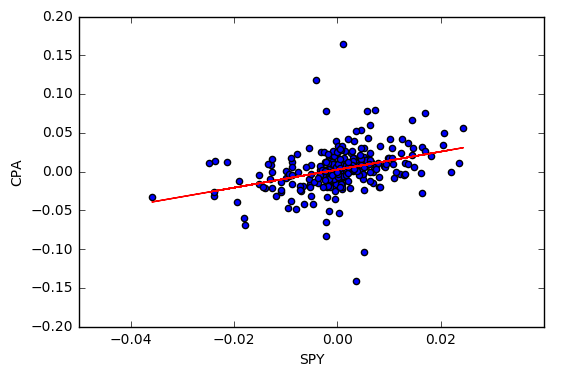

In [16]:
beta_copa, alpha_copa = np.polyfit(daily_returns['SPY'], daily_returns['CPA'], 1)
print('Beta COPA {}'.format(beta_copa))
print('Alpha COPA {}'.format(alpha_copa))

daily_returns.plot(kind='scatter', x='SPY', y='CPA')
plt.plot(daily_returns['SPY'], daily_returns['SPY'] * beta_copa + alpha_copa, '-', color='r')

plt.show()

In [17]:
daily_returns.corr(method='pearson')

,SPY,CPA,ORCL
SPY,1.000000,0.344066,0.755100
CPA,0.344066,1.000000,0.252913
ORCL,0.755100,0.252913,1.000000
